패션 아이템을 구분하는 DNN

- 패션 데이터를 모아놓은 Fashion MNIST를 이용해 패션 아이템을 구분하는 모델 실습
- 딥러닝 모델을 만들고 학습에 앞서 데이터를 모아 가공하는 작업이 필요하다.
- 토치비전이 데이터셋을 받고 학습데이터를 나누는 작업까지 진행해준다.
- torch.utils.data = 표준 데이터셋 정의 및 데이터 로드, 스플릿 등을 하는 도구들이 들어있는 모듈
- torchvision.datasets = 위의 utills.data의 이미지 데이터셋의 모음
- torchvision.transforms = 이미지 데이터셋에 이용가능한 여러가지 변환 필터를 담은 모듈
- torchvision.utils = 이미지 데이터를 저장하고 시각화 하기 위한 도구가 있는 모듈

In [1]:
#토치비전, 맷플롯립이용하여 데이터셋 관찰

#라이브러리 임포트
from torchvision import datasets, transforms, utils
from torch.utils import data
import matplotlib.pyplot as plt
import numpy as np

#이미지를 텐서로 변환
transform = transforms.Compose([transforms.ToTensor()]) #이미지 크기 조정 = Resize(), 정규화 Normalize()

#데이터 다운
trainset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transform
)
testset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = False,
    download  = True,
    transform = transform
)  # 이 때 생성된 객체는 파이토치 내부 클래스 'torch.utils.data.Dataset' 상속
   # 파이토치의 'DataLoader'에 바로 넣어 사용 가능하다. (배치로 나누고 학습시 반복문 안에서 데이터 공급하는 클래스)

Extracting ./.data/FashionMNIST\raw\train-images-idx3-ubyte.gz to ./.data/FashionMNIST\raw


Extracting ./.data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./.data/FashionMNIST\raw


Extracting ./.data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST\raw


Extracting ./.data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST\raw
Processing...


Done!


In [2]:
#데이터 로더 매개변수에 데이터를 넣어주고 배치크기 지정
batch_size = 16

train_loader = data.DataLoader( dataset = trainset,
                              batch_size = batch_size)
test_loader = data.DataLoader( dataset = testset,
                             batch_size = batch_size)

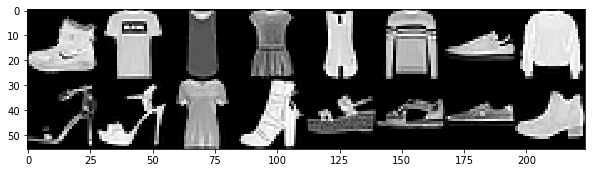

In [5]:
#데이터 확인
dataiter = iter(train_loader)
images, labels = next(dataiter)

img = utils.make_grid(images, padding =  0) # 여러 이미지를 모아 하나의 이미지로 만들기
npimg = img.numpy() #텐서를 넘파이 행렬로 바꿔 matplotlib과 호환되게 변환
plt.figure(figsize=(10,7))
plt.imshow(np.transpose(npimg, (1,2,0))) #인식 차원의 순서가 달라 0번째 차원을 맨뒤로 보낸다. 
plt.show()

In [6]:
#레이블 확인
print(labels)

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9])


In [7]:
#이미지 해석을 위한 딕셔너리 생성 
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

#labels의 영문 텍스트 출력
for label in labels :
    index = label.item()
    print(CLASSES[index])

Ankle boot
T-shirt/top
T-shirt/top
Dress
T-shirt/top
Pullover
Sneaker
Pullover
Sandal
Sandal
T-shirt/top
Ankle boot
Sandal
Sandal
Sneaker
Ankle boot


- 이미지 데이터는 가로, 세로, 색상으로 구성된 3차원 행렬로 표현된다. 
- 가로 세로는 각각의 픽셀 수, 색상값은 흑백같은경우 1가지 숫자로 표현 가능 
- 각 픽셀은 0~255의 값을 가지며 위의 예제의 이미지 크기는 28*28 색상 채널은 흑백 한가지로 입력 x의 특징값 수는 784개이다. 

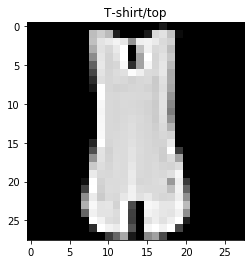

In [12]:
#개별 이미지를 꺼내보기 위한 코드 
idx = 4
item_img = images[idx]
item_npimg = item_img.squeeze().numpy() #넘파이 행렬로 변환 
plt.title(CLASSES[labels[idx].item()])
plt.imshow(item_npimg, cmap = 'gray')
plt.show()

In [39]:
#기본 심층 신경망 모델 생성 (DNN)

#라이브러리 로드 
import torch
import torch.nn as nn #인공싱경망 재료
import torch.optim as optim #최적화
import torch.nn.functional as F #nn모듈의 함수버전

#CUDA 이용여부확인 및 설정
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

#대용량의 이미지 데이터를 배치로 나눠 이용 
EPOCHS = 30
BATCH_SIZE = 64

In [40]:
#데이터 불러오기 
transform = transforms.Compose([transforms.ToTensor()])

trainset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transform
)
testset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = False,
    download  = True,
    transform = transform
)

train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
)
test_loader = torch.utils.data.DataLoader(
    dataset     = testset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
)

In [41]:
#레이어가 3개인 3층 인공신경망 
#모델 가중치 변수들이 들어가는 연산 수행
#픽셀값 784개 입력받아 가중치를 행렬곱하고 편항 더해 값 256 출력
#똑같은 과정으로 fc2, 3을거쳐 마지막 10개의 값 출력 (클래스를 나타낸다.)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784,256)
        self.fc2 = nn.Linear(256,128) 
        self.fc3 = nn.Linear(128,10)
        
#자세한 데이터 흐름의 정의 

    def forward(self, x): 
        x = x.view(-1, 784)       #입력을 받아 view함수를 이용하여 1차원 행렬 변환 후 Relu 활성화 함수 거친다.
        x = F.relu(self.fc1(x))   #nn.Linear와 같이 가중치가 있는 연산은 생성자에 선언해주는 것이 좋다. 
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [42]:
#모델 선언 및 to()함수로 연산을 어디서 수행할지 설정 
model = Net().to(DEVICE)

In [43]:
#최적화 알고리즘으로 torch내장모듈인 optim.SGD 이용(확률적 경사하강법)

optimizer = optim.SGD(model.parameters(), lr = 0.01) #학습률 0.01, 모델 내부 정보 넘겨주는 model.parameters 이용

In [44]:
#학습은 데이터를 보고 모델의 가중치 조절 작업 반복
#학습에 들어가는 모든 연산은 train()에서 해결 
def train(model, train_loader, optimizer):
    model.train()#학습모드 변경
    for batch_idx, (data, target) in enumerate(train_loader):  #모델 입력 data오양 [ 배치크기, 색, 높이, 넓이 ] 
        # 학습 데이터를 DEVICE의 메모리로 보냄
        data, target = data.to(DEVICE), target.to(DEVICE) # 학습 데이터를 DEVICE의 메모리로 보냄
        optimizer.zero_grad() #기울기 계산
        output = model(data)#학습 데이터에 대한 모델 예측값
        loss = F.cross_entropy(output, target)# 오차함수, 가중치 보관이 필요없어 criterion함수 미생성
        loss.backward()
        optimizer.step()

- 우리가 모든 모델을 생성시, 학습 데이터에만 최적화한 모델이 아닌 모든 데이터에서 높은 성능을 보이는 모델을 원한다. 
- 모든 데이터에 최적화 하는 것을 일반화라고 하며, 학습 데이터를 기반으로 한 모델이 미학습 데이터에 얼마나 적응하는지를

  수치로 나타낸 것을 '일반화 오류'라고 한다. (작을 수록 좋다. )
- 보통 머신러닝은 학습, 검증, 테스트 데이터셋으로 나누며 학습용 데이터셋은 가중치를 조절하고 
  
  검증용 데이터는 배치 크기와 모델 설계같은 하이퍼 파라미터를 조절하는데 이용하고 
  
  테스트 셋은 성능 보고에 이용한다. 

In [45]:
#epoch가 끝날 때마다 테스트 셋 모델 성능 측정
def evaluate(model, test_loader):
    model.eval() #평가모드로 전환
    test_loss = 0
    correct = 0#테스트 오차와 예측이 맞은 변수를 0으로 초기화 
    with torch.no_grad(): #평가 과정은 기울기 계산 필요 없음.
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 모든 오차 더하기
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item() #reduction = 'sum'지정으로 미니배치 평균이 아닌 합을 받아온다. 
            
            # 가장 큰 값을 가진 클래스가 모델의 예측입니다.
            # 예측과 정답을 비교하여 일치할 경우 correct에 1을 더합니다.
            pred = output.max(1, keepdim=True)[1]#가장 큰값과, 인덱스 출력
            correct += pred.eq(target.view_as(pred)).sum().item()#각 배치마다 정답 맞힌 개수 합

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)#테스트 셋 데이터 수로 나눠 평균을 구하여 오차와 맞힌 개수를 100에 곱하여 정확도 구하기 
    return test_loss, test_accuracy

In [46]:
#실제 학습
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print('[{}] TEST Loss : {}, Accuracy : {}%'.format(epoch, test_loss, test_accuracy))

[1] TEST Loss : 0.836657514667511, Accuracy : 68.43%
[2] TEST Loss : 0.6700313878059387, Accuracy : 75.95%
[3] TEST Loss : 0.597106874704361, Accuracy : 78.74%
[4] TEST Loss : 0.5545449652671814, Accuracy : 80.38%
[5] TEST Loss : 0.525996725845337, Accuracy : 81.27%
[6] TEST Loss : 0.5019499384880066, Accuracy : 81.92%
[7] TEST Loss : 0.48382047057151795, Accuracy : 82.88%
[8] TEST Loss : 0.49915523371696474, Accuracy : 82.19%
[9] TEST Loss : 0.46939105978012086, Accuracy : 83.0%
[10] TEST Loss : 0.467610990524292, Accuracy : 83.27%
[11] TEST Loss : 0.44304250450134275, Accuracy : 84.26%
[12] TEST Loss : 0.4371254809379578, Accuracy : 84.62%
[13] TEST Loss : 0.4385742992401123, Accuracy : 84.47%
[14] TEST Loss : 0.4310720860004425, Accuracy : 84.76%
[15] TEST Loss : 0.42036981868743895, Accuracy : 84.97%
[16] TEST Loss : 0.41772903327941896, Accuracy : 85.29%
[17] TEST Loss : 0.4123927303314209, Accuracy : 85.4%
[18] TEST Loss : 0.406612428188324, Accuracy : 85.57%
[19] TEST Loss : 0.4